This notebook is intended to show the process of implementing a custom method to work with the composer trainer. In order, it will cover
* Implementing a method using standard pytorch
* Brief overview of events and state in composer
* Modifying the implementation to work with composer
* Composing multiple methods together

We should see that getting a method working with composer is not very different from getting it working with vanilla pytorch, we just need to wrap it with a few extra things so that composer knows how to run it.


# Install composer

First, installation

In [ ]:
!pip install mosaicml 
!pip install matplotlib

# Implementing a method with pytorch

In this section, we'll go through the process of implementing a new method without using composer. First, some relevant imports

In [ ]:
import torch
from torchvision import datasets, transforms

torch.manual_seed(42)

import matplotlib.pyplot as plt

Now, set up some training data. For simplicity, we will use CIFAR10 with minimal preprocessing

In [ ]:
mean = (0.507, 0.487, 0.441)
std = (0.267, 0.256, 0.276)

c10_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=c10_transforms)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=c10_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)

Next, we will define a model. For this, we will simply use composer's ResNet56. For using your own custom model, please see the [custom models tutorial](https://docs.mosaicml.com/en/stable/tutorials/adding_models_datasets.html#models). One quirk to be aware of with this model is that the forward method takes in an (X, y) pair of inputs and targets, essentially what the dataloaders will spit out.

In [ ]:
from composer import models
model = models.CIFAR10_ResNet56(num_classes=10)

Now we'll define a function to test the model

In [ ]:
def test(model, test_loader, device='cuda'):
  model.to(device)
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model((data, target))
      output = torch.nn.functional.log_softmax(output, dim=1)
      test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  print('\nTest set Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

Now, we will train it for a single epoch to check that things are working. We'll also test before and after training to check how accuracy changes.

In [ ]:
%%time
device = 'cuda'
model.to(device)
test(model, test_dataloader)

optimizer = torch.optim.Adam(model.parameters())
model.train()
for batch_idx, (data, target) in enumerate(train_dataloader):
  data, target = data.to(device), target.to(device)
  optimizer.zero_grad()
  output = model((data, target))
  output = torch.nn.functional.log_softmax(output, dim=1)
  loss = torch.nn.functional.nll_loss(output, target)
  loss.backward()
  optimizer.step()

test(model, test_dataloader)

Looks like things are working! Time to implement our own modification to the training procdedure.



For this tutorial, we'll look at how to implement one of the simpler speedup methods currently in our composer library: [ColOut](https://docs.mosaicml.com/en/stable/method_cards/col_out.html). This method works on image data by dropping random rows and columns from the training images. This reduces the size of the training images, which reduces the time per training iteration, and hopefully does not alter the semantic content of the image too much. Additionally, dropping a small fraction of random rows and columns can also slightly distort objects, and perhaps provide a data augmentation effect.

To start our implementation, we'll write a function to drop random rows and columns from a batch of input images. We'll assume that these are torch tensors and operate on a batch rather than individual images for simplicity here.



In [ ]:
def batch_colout(X, p_row, p_col):
  # Get the dimensions of the image
  row_size = X.shape[2]
  col_size = X.shape[3]

  # Determine how many rows and columns to keep
  kept_row_size = int((1 - p_row) * row_size)
  kept_col_size = int((1 - p_col) * col_size)

  # Randomly choose indices to keep. Must be sorted for slicing
  kept_row_idx = sorted(torch.randperm(row_size)[:kept_row_size].numpy())
  kept_col_idx = sorted(torch.randperm(col_size)[:kept_col_size].numpy())

  # Keep only the selected row and columns
  X_colout = X[:, :, kept_row_idx, :]
  X_colout = X_colout[:, :, :, kept_col_idx]
  return X_colout

This is very simple, but as a check, we should visualize what this does to the data:


In [ ]:
X, y = next(iter(train_dataloader))

X_colout_1 = batch_colout(X, 0.1, 0.1)
X_colout_2 = batch_colout(X, 0.2, 0.2)
X_colout_3 = batch_colout(X, 0.3, 0.3)

def unnormalize(X, mean, std):
  X *= torch.tensor(std).view(1, 3, 1, 1)
  X += torch.tensor(mean).view(1, 3, 1, 1)
  X = X.permute(0,2,3,1)
  return X

X = unnormalize(X, mean, std)
X_colout_1 = unnormalize(X_colout_1, mean, std)
X_colout_2 = unnormalize(X_colout_2, mean, std)
X_colout_3 = unnormalize(X_colout_3, mean, std)

fig, axes = plt.subplots(1, 4, figsize=(20,5))
axes[0].imshow(X[0])
axes[0].set_title("Unmodified", fontsize=18)
axes[1].imshow(X_colout_1[0])
axes[1].set_title("p_row = 0.1, p_col = 0.1", fontsize=18)
axes[2].imshow(X_colout_2[0])
axes[2].set_title("p_row = 0.2, p_col = 0.2", fontsize=18)
axes[3].imshow(X_colout_3[0])
axes[3].set_title("p_row = 0.3, p_col = 0.3", fontsize=18)

for ax in axes:
  ax.axis('off')
plt.show()

Looks like things are behaving as they should! Now let's insert it into our training loop. We'll also reinitialize the model here for a fair comparison with our earlier one epoch run.

In [ ]:
model = models.CIFAR10_ResNet56(num_classes=10)

And do colout on the batch of data that the dataloader spits out:

In [ ]:
%%time
device = 'cuda'
p_row = 0.15
p_col = 0.15
model.to(device)
test(model, test_dataloader)

optimizer = torch.optim.Adam(model.parameters())
model.train()
for batch_idx, (data, target) in enumerate(train_dataloader):
  data, target = data.to(device), target.to(device)
  ### Insert ColOut here ###
  data = batch_colout(data, p_row, p_col)
  ### ------------------ ###
  optimizer.zero_grad()
  output = model((data, target))
  output = torch.nn.functional.log_softmax(output, dim=1)
  loss = torch.nn.functional.nll_loss(output, target)
  loss.backward()
  optimizer.step()

test(model, test_dataloader)

Accuracy is pretty similar, and the wall clock time is definitely faster. Perhaps this method does provide a speedup in this case, but to do a proper evaluation we would want to look at the pareto curves, similar to the data in our [explorer](https://app.mosaicml.com/explorer/imagenet).

This style of implementation is similar to the functional implementations in the composer library. Since ColOut is already implemented there, we could have simply done 


In [ ]:
from composer import functional as CF

And insert ColOut into our training loop with

In [ ]:
data = CF.colout_batch(data, p_row, p_col)

A natural question here is how do we combine ColOut with other methods? One way to do so would be to simply repeat the process we went through above for each method we want to try, inserting it in the training loop where appropriate. However, this can quickly become unweildy, and makes it difficult to run experiments using many different combinations of methods. This is the problem composer aims to solve. 

In the following sections, we will modify our above implementation to work with composer so we can run many methods together. The modifications we need to make are fairly simple, in essence we just need a way to tell composer where in the training loop to insert our method, and track the appropriate objects our method acts on. With composer, we can insert our method into the training loop at what composer calls an `event`, and track what our method needs to modify in what composer calls `state`.

# Events and state in composer

The training loop composer uses provides multiple different locations where method code can be inserted and run. These are called events. Diagramatically the training loop looks as follows:

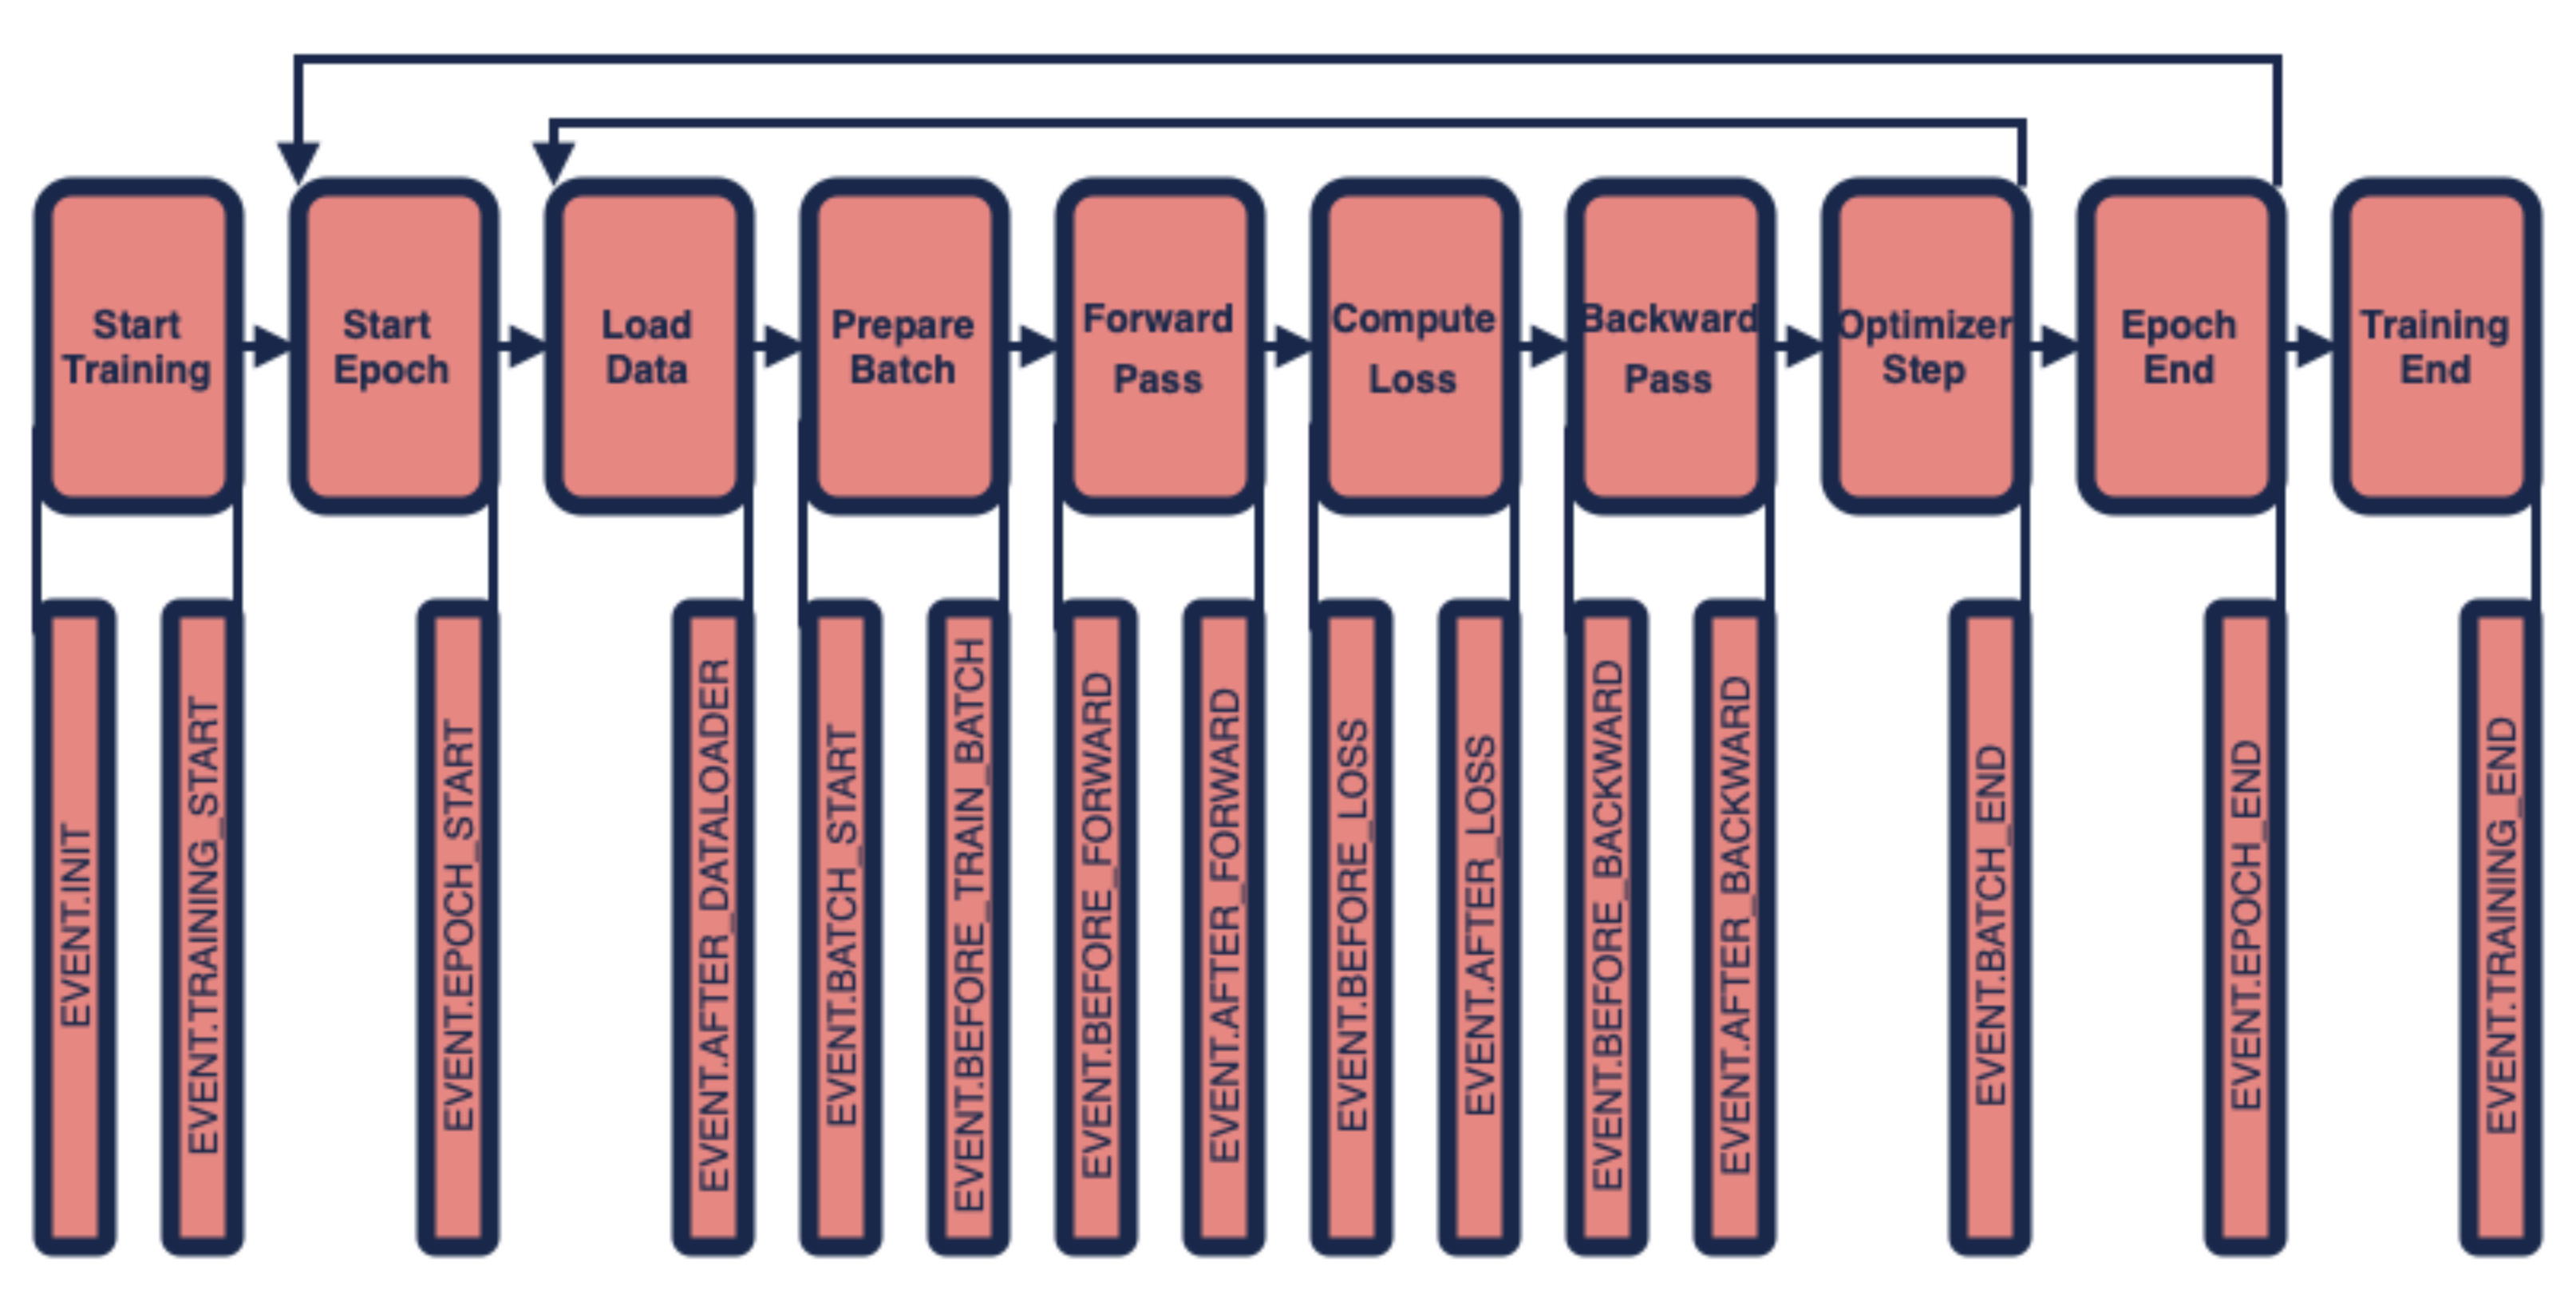

At the top, we see the different steps of the composer training loop. At the bottom, we see the many events that occur at different places within the training loop. For example, the event `EVENT.BEFORE_FORWARD` occurs just before the forward pass through the model, but after dataloading and preprocessing has taken place. These events are the points at which we can run the code for the method we want to implement.

Most methods require making modification so some object used in training, such as the model itself, the input/output data, training hyperparameters, etc. These quantities are tracked in composer's `State` object, which can be found [here](https://github.com/mosaicml/composer/blob/dev/composer/core/state.py). 

# Implementing a method with composer

Now it's time to set up our method to work with composer's trainer. To do this we will wrap the ColOut transformation we wrote up above in a class that inherits from composer's base `Algorithm` class. Then we will need to implement two methods within that class, a `match` method that tells composer which `event` we want ColOut to run on, and an `apply` method that tells composer how to run ColOut. First, some relevant imports from composer:


In [ ]:
from composer import Trainer
from composer.core import Algorithm, Event

Before, we inserted ColOut into the training loop after getting a batch from the dataloader, but before the forward pass, it makes sense for us to run ColOut on the event `EVENT._AFTER_DATALOADER`. The `match` method for this will simply check that the current event is this one and return `True` if it is, and `False` otherwise.

In [ ]:
def match(self, event, state):
  return event == Event.AFTER_DATALOADER

The `apply` method is also simple in this case, it will just tell composer how to run the function we already wrote, and how to save the results in `state`

In [ ]:
def apply(self, event, state, logger):
  inputs, labels = state.batch
  new_inputs = batch_colout(inputs, p_row=self.p_row, p_col=self.p_col)
  state.batch = (new_inputs, labels)

Packaging this together into an algorithm class gives our full composer ready ColOut implementation:

In [ ]:
class ColOut(Algorithm):
  def __init__(self, p_row=0.15, p_col=0.15):
    self.p_row = p_row
    self.p_col = p_col

  def match(self, event, state):
    return event == Event.AFTER_DATALOADER

  def apply(self, event, state, logger):
    inputs, labels = state.batch
    new_inputs = batch_colout(inputs, p_row=self.p_row, p_col=self.p_col)
    state.batch = (new_inputs, labels)

Now we'll create a model, optimizer and test it the same way as before

In [ ]:
model = models.CIFAR10_ResNet56(num_classes=10)
optimizer = torch.optim.Adam(model.parameters())

Time to initialize the trainer. We'll have to give it our `model`, and the two dataloaders. We'll tell the trainer to run for one epoch by setting `max_duration='1ep'` and run on the gpu by setting `device='gpu'`. Since we're handling the testing ourselves in this example, we'll turn off composer's validation by setting `validate_every_n_epochs=-1` and set the seed.

In [ ]:
trainer = Trainer(model=model,
                  train_dataloader=train_dataloader,
                  eval_dataloader=test_dataloader,
                  optimizers=optimizer,
                  max_duration='1ep',
                  device='gpu',
                  validate_every_n_epochs=-1,
                  seed=42)

In [ ]:
%%time
test(model, test_dataloader)
trainer.fit()
test(model, test_dataloader)

Now to add ColOut. We'll recreate the model and optimizer, and also create an instance of the ColOut class we implemented above.

In [ ]:
model = models.CIFAR10_ResNet56(num_classes=10)
optimizer = torch.optim.Adam(model.parameters())
colout_method = ColOut()

All that's left now is to pass the `colout_method` object to the composer trainer, which is otherwise initialized the same way as before. To do this, we just need to set `algorithms=[colout_method]`.

In [ ]:
trainer = Trainer(model=model,
                  train_dataloader=train_dataloader,
                  eval_dataloader=test_dataloader,
                  optimizers=optimizer,
                  max_duration='1ep',
                  device='gpu',
                  algorithms=[colout_method],
                  validate_every_n_epochs=-1,
                  seed=42)

In [ ]:
%%time
test(model, test_dataloader)
trainer.fit()
test(model, test_dataloader)

# Composing multiple methods

Here we'll compose our custom ColOut method with another method from the composer library, `BlurPool`. 

In [ ]:
from composer.algorithms.blurpool import BlurPool

Set up the blurpool object

In [ ]:
blurpool = BlurPool(replace_convs=True, replace_maxpools=True, blur_first=True)

And add it to the list of methods for the trainer to run. In general, we can pass in as many methods as we want, and composer should know how to run them all together.

In [ ]:
model = models.CIFAR10_ResNet56(num_classes=10)
optimizer = torch.optim.Adam(model.parameters())
trainer = Trainer(model=model,
                  train_dataloader=train_dataloader,
                  eval_dataloader=test_dataloader,
                  optimizers=optimizer,
                  max_duration='1ep',
                  device='gpu',
                  algorithms=[colout_method, blurpool],
                  validate_every_n_epochs=-1,
                  seed=42)

In [ ]:
%%time
test(model, test_dataloader)
trainer.fit()
test(model, test_dataloader)

# Other methods as examples

The above implementation is one of the simplest cases. For more complex methods, the process is the same, but might require using different `events`, or modifying different things in `state`. Here are some interesting examples of other methods in the composer library:

[BlurPool](https://github.com/mosaicml/composer/blob/ed83675bda82047ad90962df3a6ae23f6c66652a/composer/algorithms/blurpool/blurpool.py) swaps out some of the layers of the network

[LayerFreezing](https://github.com/mosaicml/composer/blob/ed83675bda82047ad90962df3a6ae23f6c66652a/composer/algorithms/layer_freezing/layer_freezing.py) changes which network parameters are trained at different epochs.

[RandAugment](https://github.com/mosaicml/composer/blob/ed83675bda82047ad90962df3a6ae23f6c66652a/composer/algorithms/randaugment/randaugment.py) Adds an additional data augmentation

[SelectiveBackprop](https://github.com/mosaicml/composer/blob/ed83675bda82047ad90962df3a6ae23f6c66652a/composer/algorithms/selective_backprop/selective_backprop.py) Changes which samples are used to compute gradients

[SAM](https://github.com/mosaicml/composer/blob/ed83675bda82047ad90962df3a6ae23f6c66652a/composer/algorithms/sam/sam.py) Changes the optimizer used for training

